# Лабораторная работа №5
## $1 | \text{s-batch} | \sum{w_ic_i}$

**Задача**: собрать работы в группы для обработки на одной машине так, чтобы
минимизировать взвешенную сумму окончания всех работ. В каждой группе
время окончания работ равно времени окончания последней работы в группе. 
Длительность выполнения всей группы работ равна сумме длительностей
работ. При переходе от одной группы к другой машина требует переналадки
$\tau$ (простой.) 

Реализовать алгоритм решения с помощью библиотеки Pyomo и собственный жадный алгоритм для решения данной задачи, создать универсальный формат задания задачи.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import networkx as nx
from functools import reduce
import pandas as pd
import shutil
import sys
import json
import os.path
from pyomo.environ import *
from pyomo.gdp import *
from pyomo.contrib.latex_printer import latex_printer
import script

In [2]:
# Запись задачи в JSON формат
def WriteJson(dictionary: dict, name = "task.json"):
    with open(name, 'w') as f:
        json.dump(dictionary, f)

# Чтение задачи из JSON формата
def ReadJson(name = "task.json") -> dict:
    with open(name, 'r') as f:
        m = json.loads(f.read())
        return m

In [3]:
# Отрисовка диаграммы Ганта
def Gantt(JOBS, SCHEDULE={}, ax1=None, ax2=None):
    bw = 0.3

    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        ax1.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='cyan', alpha=0.6)
        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            ax1.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            ax1.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            ax1.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    ax1.set_ylim(-0.5, idx-0.5)
    ax1.set_title('Job Schedule')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Jobs')
    ax1.set_yticks(range(len(JOBS)), JOBS.keys())
    ax1.grid()
    xlim = ax1.get_xlim()

    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            ax2.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            ax2.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            ax2.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j + SCHEDULE[j]['meta'], color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        ax2.set_xlim(xlim)
        ax2.set_ylim(-0.5, len(MACHINES)-0.5)
        ax2.set_title('Machine Schedule')
        ax2.set_yticks(range(len(MACHINES)), MACHINES)
        ax2.set_ylabel('Machines')
        ax2.grid()

# Подсчет метрик для решенной задачи
def Kpi(JOBS, SCHEDULE):
    KPI = {}
    KPI['Makespan'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE)
    KPI['Max Pastdue'] = max(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['AE due'] = max(abs(SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Sum of Pastdue'] = sum(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Number Pastdue'] = sum(SCHEDULE[job]['finish'] > JOBS[job]['due'] for job in SCHEDULE)
    KPI['Number on Time'] = sum(SCHEDULE[job]['finish'] <= JOBS[job]['due'] for job in SCHEDULE)
    KPI['Fraction on Time'] = KPI['Number on Time']/len(SCHEDULE)
    return KPI

## Реализация в Pyomo

In [4]:
def ObjectiveF(JOBS, MACHINES, TAU, z):
    # матрица длительности i работы в j ой группе (на j машине)
    TMAX = [[0 for _ in range(len(MACHINES))] for _ in range(len(JOBS))]
    # матрица веса i работы в jой группе (на j машине)
    ZMAX = [[0 for _ in range(len(MACHINES))] for _ in range(len(JOBS))]
    # суммарная длительность работ в j ой группе (на j машине)
    MAX = [0] * len(MACHINES)
    # суммарный вес работ в j ой группе (на j машине)
    WMAX = [0] * len(MACHINES)
    MAX_adapt = [0] * len(MACHINES)
    string = list(JOBS.keys())

    for j in range(len(MACHINES)):
        for i in range(len(JOBS)):
            TMAX[i][j] = JOBS[string[i]]['duration'] * z[string[i], MACHINES[j]]
            ZMAX[i][j] = JOBS[string[i]]['weight'] * z[string[i], MACHINES[j]]
            MAX[j] += TMAX[i][j]
            WMAX[j] += ZMAX[i][j]

    MAX_adapt[0] = MAX[0] + 1
    for j in range(1, len(MACHINES)):
        MAX_adapt[j] = MAX_adapt[j - 1] + MAX[j] + TAU

    objective = 0
    for j in range(len(MACHINES)):
        objective += MAX_adapt[j] * WMAX[j]

    return objective

def z_init(m, j, mach):
    if mach == "G0":
        return 1

    return 0

#Создание метода решения
def ScheduleMachines(JOBS, MACHINES, TAU):

    m = ConcreteModel()

    m.J = Set(initialize=JOBS.keys())
    m.M = Set(initialize=MACHINES)
    m.z = Var(m.J, m.M, domain=Binary, initialize=z_init)
    
    m.OBJ = Objective(expr = ObjectiveF(JOBS, MACHINES, TAU, m.z), sense = minimize)

    m.c1 = Constraint(m.J, rule=lambda m, j:
            sum(m.z[j,mach] for mach in m.M) == 1)

#     m.display()
    solver = SolverFactory("bonmin", executable=r"..\solvers\ampl.mswin64\bonmin.exe", tee=True)
    solver.solve(m)

    SCHEDULE = {}
    group_start = [0] * len(MACHINES)
    group_start[0] = TAU
    
    # матрица длительности i работы в j ой группе (на j машине)
    TMAX = [[0 for _ in range(len(MACHINES))] for _ in range(len(JOBS))]
    string = list(JOBS.keys())

    for j in range(len(MACHINES)):
        for i in range(len(JOBS)):
            TMAX[i][j] = JOBS[string[i]]['duration'] * m.z[string[i], MACHINES[j]]()

    for j in range(1, len(MACHINES)):
        group_start[j] = group_start[j - 1] + sum(TMAX[i][j - 1] for i in range(len(JOBS))) + TAU
    
    for j in m.J:
        group_idx = [idx for idx, mach in enumerate(MACHINES) if m.z[j,mach]()][0]
        SCHEDULE[j] = {
            'start': group_start[group_idx],
            'finish': group_start[group_idx] + JOBS[j]['duration'],
            'machine': "M1", 
            'meta': f"\nG: {group_idx}\nW: {JOBS[j]['weight']}"
        }
        
        group_start[group_idx] += JOBS[j]['duration']

    matrix = [[0 for _ in range(len(JOBS))] for _ in range(len(JOBS))]
    jobs = list(JOBS.keys())
    for i in range(len(JOBS)):
        for j in range(len(JOBS)):
            matrix[i][j] = 1 if m.z[jobs[i], MACHINES[j]]() > 0 else 0

    return SCHEDULE, m.OBJ(), matrix

## Жадный алгоритм $O(C \cdot n^4)$

In [5]:
def Score(JOBS, TAU, matrix):
    N = len(JOBS)
    score = 0
    start = 0
    
    jobs = list(JOBS.keys())
    
    for j in range(N):
        start += TAU
        group_duration = 0
        group_weight = 0
        
        for i in range(N):
            if matrix[i][j] == 1:
                group_duration += JOBS[jobs[i]]["duration"]
                group_weight += JOBS[jobs[i]]["weight"]

        start += group_duration
        score += start * group_weight

    return score

def MakeSheduler(JOBS, TAU, matrix):
    result = {}
    N = len(JOBS)
    start = 0
    
    jobs = list(JOBS.keys())
    
    for j in range(N):
        start += TAU
        
        for i in range(N):
            if matrix[i][j] == 1:
                result[jobs[i]] = {
                    'start': start,
                    'finish': start + JOBS[jobs[i]]["duration"],
                    'machine': "M1",
                    'meta': f"\nG: {j}\nW: {JOBS[jobs[i]]['weight']}",
                }
                start += JOBS[jobs[i]]["duration"]
    
    return result

def Solve(JOBS, TAU):
    N = len(JOBS)
    matrix = [[0 for _ in range(N)] for _ in range(N)]
    for i in range(N):
        matrix[i][0] = 1
        
    best_score = Score(JOBS, TAU, matrix)
    get_better = True
    
    while get_better:
        get_better = False
        for idx in range(N):
            best_j = 0
            
            for j in range(N):
                if matrix[idx][j]:
                    best_j = j
                matrix[idx][j] = 0

            for j in range(N):
                
                matrix[idx][j] = 1

                score = Score(JOBS, TAU, matrix)
                if score < best_score:
                    get_better = True
                    best_score = score
                    best_j = j

                matrix[idx][j] = 0

            matrix[idx][best_j] = 1

    return MakeSheduler(JOBS, TAU, matrix), best_score, matrix

In [6]:
def Test(name, verbose = False):
    DATA = ReadJson(name=name)

    #Задание словаря работ
    JOBS = DATA["JOBS"]
    
    MACHINES = [f"G{i}" for i in range(len(JOBS))]
    TAU = DATA["TAU"]

    SCHEDULE1, score1, mat1 = ScheduleMachines(JOBS.copy(), MACHINES, TAU)
    SCHEDULE2, score2, mat2 = Solve(JOBS.copy(), TAU)
    
    if not verbose:
        fig, ax = plt.subplots(3, 2, figsize=(18,18))
        fig.suptitle(f"{name}\nBest: {score1}\nGreedy: {score2}")
        ax[0][0].matshow(mat1)
        ax[0][1].matshow(mat2)

        Gantt(JOBS, SCHEDULE1, ax[1][0], ax[2][0])
        Gantt(JOBS, SCHEDULE2, ax[1][1], ax[2][1])

    return score1, score2

In [7]:
df = pd.DataFrame(columns=["Jobs count", "Max duration", "Max weight", "Score", "my Score", "Delta"])
idx = 0
for jobs_count in range(2, 7):
        for max_duration in [3, 7, 14, 20]:
            for max_weight in [5, 10, 15, 20]:
                idx += 1

                WriteJson(script.create_task(jobs_count, max_duration, 0, 20, max_weight))
                DATA = ReadJson(name="task.json")
                JOBS = DATA["JOBS"]

                s1, s2 = Test("task.json", verbose = True)

                df.loc[idx] = [jobs_count, max_duration, max_weight, s1, s2, abs(s2-s1) if s1 is not None else None]

                print(f"[{idx}] Task with params: {[jobs_count, max_duration, max_weight]} solved.")

[1] Task with params: [2, 3, 5] solved.
[2] Task with params: [2, 3, 10] solved.
[3] Task with params: [2, 3, 15] solved.
[4] Task with params: [2, 3, 20] solved.
[5] Task with params: [2, 7, 5] solved.
[6] Task with params: [2, 7, 10] solved.
[7] Task with params: [2, 7, 15] solved.
[8] Task with params: [2, 7, 20] solved.
[9] Task with params: [2, 14, 5] solved.
[10] Task with params: [2, 14, 10] solved.
[11] Task with params: [2, 14, 15] solved.
[12] Task with params: [2, 14, 20] solved.
[13] Task with params: [2, 20, 5] solved.
[14] Task with params: [2, 20, 10] solved.
[15] Task with params: [2, 20, 15] solved.
[16] Task with params: [2, 20, 20] solved.
[17] Task with params: [3, 3, 5] solved.
[18] Task with params: [3, 3, 10] solved.
[19] Task with params: [3, 3, 15] solved.
[20] Task with params: [3, 3, 20] solved.
[21] Task with params: [3, 7, 5] solved.
[22] Task with params: [3, 7, 10] solved.
[23] Task with params: [3, 7, 15] solved.
[24] Task with params: [3, 7, 20] solved.

In [8]:
df

,Jobs count,Max duration,Max weight,Score,my Score,Delta
1,2.0,3.0,5.0,54.0,54.0,0.0
2,2.0,3.0,10.0,60.0,60.0,0.0
3,2.0,3.0,15.0,94.0,94.0,0.0
4,2.0,3.0,20.0,98.0,98.0,0.0
5,2.0,7.0,5.0,28.0,32.0,4.0
...,...,...,...,...,...,...
76,6.0,14.0,20.0,1746.0,1812.0,66.0
77,6.0,20.0,5.0,263.0,267.0,4.0
78,6.0,20.0,10.0,731.0,758.0,27.0
79,6.0,20.0,15.0,1008.0,1050.0,42.0


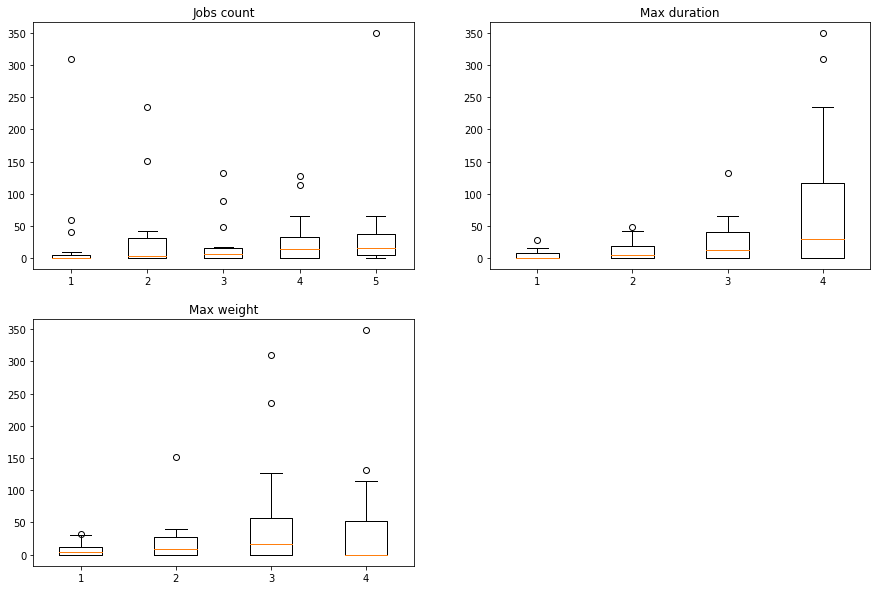

In [9]:
plt.subplots(figsize=(15,10))
for idx, param in enumerate(['Jobs count', 'Max duration', 'Max weight']):
    df1 = df.groupby([param]).mean()
    plt.subplot(221 + idx, title=param)
    plt.boxplot([df[df[param] == i]["Delta"].values for i in df1.index.values])

plt.show()

(583.0, 591)

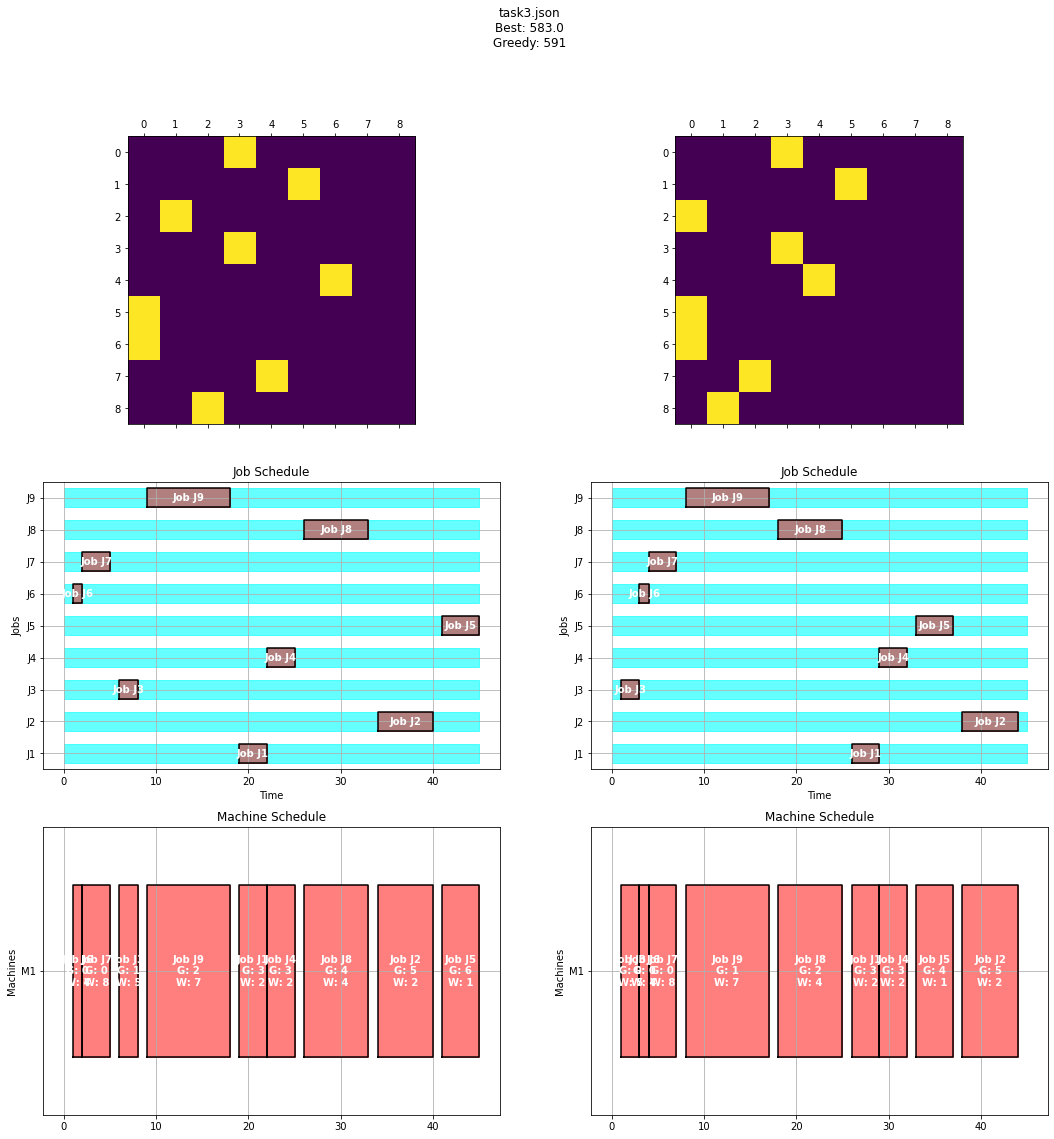

In [10]:
Test("task3.json")

## Вывод

В ходе лабораторной работы я решил $1 | \text{s-batch} | \sum{w_ic_i}$ проблему с помощью фреймворка Pyomo, предоставляющего интерфейс для постановки задач линейного программирования и передачей их решателям. А также разработал собственный жадный алгоритм, который выполняет раунды, иттерации, пытаясь срелаксировать и сойтись к оптимальному решению. Несмотря на временную сложность, в среднем алгоритм работает не очень долго, а также имеется гарантия, что рано или поздно алгоритм остановится. Прослеживается корреляция между ошибкой жадного алгоритма и средней длительностью работ, что вполне предсказуемо, так как в расчете ошибки учавствует длительность работ. Однако в целом алгоритм оказался крайне эффективным.